# CP 5 Aprendizaje de Máquinas

---


## Support Vector Machine y Cross Validation


## Ejercicio 1: Preprocesamiento del Dataset

Vamos a trabajar con un dataset que contiene información acerca de pacientes (*gender, marital status, smoking status, age, etc*) con el ojetivo de predecir si es probable que tenga un ataque al corazón (*stroke*).
Además se incorpora de manera artificial la característica *doctor* que representa el doctor que recolectó los datos, la cual más adelante será usada para agrupar los datos.

In [1]:
import pandas as pd
import numpy as np

def get_prep_data():
    df = pd.read_csv(
        "./resources/healthcare-dataset-stroke-data.csv"
    )
    df["ever_married"] = (
        df["ever_married"].replace("Yes", True).replace("No", False)
    )
    df["gender"] = df["gender"].astype("category")
    df["smoking_status"] = df["smoking_status"].astype("category")
    df["Residence_type"] = df["Residence_type"].astype("category")
    df["work_type"] = df["work_type"].astype("category")
    df["doctor"] = np.random.randint(0, 8, size=len(df))
    
    return df


df = get_prep_data()

A continuación exploremos la estructura del dataset en cuestión:

In [2]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,doctor
0,9046,Male,67.0,0,1,True,Private,Urban,228.69,36.6,formerly smoked,1,2
1,51676,Female,61.0,0,0,True,Self-employed,Rural,202.21,NaN,never smoked,1,1
2,31112,Male,80.0,0,1,True,Private,Rural,105.92,32.5,never smoked,1,7
3,60182,Female,49.0,0,0,True,Private,Urban,171.23,34.4,smokes,1,6
4,1665,Female,79.0,1,0,True,Self-employed,Rural,174.12,24.0,never smoked,1,1


Se observan variables categóricas las cuales es necesario codificar 

Para codificar las variables categóricas que están representadas en el dataset como string, podemos usar un encoder de `sklearn`, `LabelEncoder`, que codifica los strings como números. El objetivo de la función `encode_features`, es dado un dataset como `DataFrame`, y una lista de características para codificar, modificar el dataset pasado como parámetro con las carcaterísticas codificadas

In [3]:
from sklearn.preprocessing import LabelEncoder
from typing import List

In [4]:
def encode_features(df: pd.DataFrame, features: List[str]):
    for feat in features:
        le = LabelEncoder()
        df[feat] = le.fit_transform(df[feat])

Llamemos a la función, pasando las características que vimos que eran categóricas

In [5]:
encode_features(df, ['gender', 'work_type', 'Residence_type', 'smoking_status'])

Observemos el dataset resultante:

In [6]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,doctor
0,9046,1,67.0,0,1,True,2,1,228.69,36.6,1,1,2
1,51676,0,61.0,0,0,True,3,0,202.21,NaN,2,1,1
2,31112,1,80.0,0,1,True,2,0,105.92,32.5,2,1,7
3,60182,0,49.0,0,0,True,2,1,171.23,34.4,3,1,6
4,1665,0,79.0,1,0,True,3,0,174.12,24.0,2,1,1


Comprobemos si para todas las muestras observadas en el dataset se tienen valores válidos. Para ello no deben existir valores `NaN`

In [7]:
df.isna().any()

id                   False
gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status       False
stroke               False
doctor               False
dtype: bool

En caso de existir valores `NaN` estos deben ser eliminados o reemplazados por algún otro valor que sea válido y represente la ausencia de información para esa muestra.

- Para reemplazar los valores `NaN`, se puede hacer uso de la función `fillna`, que recibe como parámetro el valor por el cual se quieren sustituir los valores `NaN`, esta función retorna un nuevo dataset con los valores sustituidos, o modifica el dataset existente al añadir el parámetro `inplace=True`

- Para eliminar las filas que tienen un valor `NaN` se puede usar la función `dropna`. En caso de usar esta función, se debe además usar la función `reset_index(drop=True)`, para arreglar los índices del `DataFrame`. Ambas funciones retornan un nuevo dataset, modifican el dataset original con el parámetro `inplace=True`

In [43]:
# Solución alternativa que reemplaza los valores Nan por -1
# df['bmi'].fillna(-1, inplace=True)

df = df.dropna().reset_index(drop=True)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,doctor
0,9046,1,67.0,0,1,True,2,1,228.69,36.6,1,1,2
1,31112,1,80.0,0,1,True,2,0,105.92,32.5,2,1,7
2,60182,0,49.0,0,0,True,2,1,171.23,34.4,3,1,6
3,1665,0,79.0,1,0,True,3,0,174.12,24.0,2,1,1
4,56669,1,81.0,0,0,True,2,1,186.21,29.0,1,1,4


Comprobemos la cantidad de muestras correspondientes a cada clase (1 para stroke, 0 para no stroke)

In [9]:
df['stroke'].value_counts()

0    4700
1     209
Name: stroke, dtype: int64

Como se puede apreciar estamos en presencia de un dataset altamente desbalanceado

La función `get_X_y` separa el dataset según las columnas elegidas como características y la columna *stroke* que representa el objetivo a predecir. Además se separa la columna *doctor* por la cual se quiere agrupar.

In [10]:
def get_X_y(train):
    FEATURES = [
        "gender",
        "age",
        "hypertension",
        "heart_disease",
        "ever_married",
        "work_type",
        "Residence_type",
        "avg_glucose_level",
        "bmi",
        "smoking_status",
    ]

    GROUPS = "doctor"

    TARGET = "stroke"

    X = train[FEATURES]
    y = train[TARGET]
    groups = train[GROUPS]
    return X, y, groups

## Ejercicio 2: Clasificación usando Support Vector Machine

Se divide el dataset en conjunto de entrenamiento y conjunto de prueba.

In [11]:
from sklearn.model_selection import train_test_split

X, y, groups = get_X_y(df)
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.1)

Proponemos usar la clase `SVC` como implementación para Support Vector Machine, la cual podemos encontrar en `sklearn`, para entrenar un clasificador en el conjunto de entrenamiento obtenido. Por defecto `SVC` usa `rbf` como función de kernel. Es necesario inicializar el parámetro `probability` como `True` para poder obtener las probabilidades de la predicción, que serán usadas para evaluar el clasificador.

In [12]:
from sklearn.svm import SVC

In [13]:
clf = SVC(probability = True)
clf.fit(X_tr, y_tr)

SVC(probability=True)

### Métricas

Dado que estamos en presencia de un dataset desbalanceado es recomendado usar otras métricas en lugar de accuracy.

En este caso proponemos usar AUC (Area Under the Curve) la cual es una medida de la habilidad del clasificador para distinguir entre las clases y se usa como una representación de la curva ROC. Cuanto mayor sea el AUC, mejor será el rendimiento del modelo para distinguir entre las clases positivas y negativas

Una curva ROC (receiver operating characteristic curve) es un gráfico que muestra el rendimiento de un modelo de clasificación en todos los umbrales de clasificación. Esta curva traza dos parámetros:
- TPR = TP / (TP + FN)
- FPR = FP / (FP + TN)

TPR frente a FPR son trazados en diferentes umbrales de clasificación. Reducir el umbral de clasificación clasifica más elementos como positivos, lo que aumenta tanto los falsos positivos como los verdaderos positivos. La siguiente figura muestra una curva ROC típica.

![aucphoto](./resources/auc.jpg)

AUC la podemos encntrar en `sklearn.metrics` como `roc_auc_score`

In [35]:
from sklearn.metrics import accuracy_score, roc_auc_score

Evaluemos el modelo usando las métricas accuracy y AUC. 

Hay que tener en cuenta que a diferencia de accuracy que evalúa segun las clases resultantes de la predicción, en el caso de AUC se van a usar las probabilidades.

In [42]:
acc_score = accuracy_score(y_val, clf.predict(X_val))
auc_score = roc_auc_score(y_val, clf.predict_proba(X_val)[:,1])
print(f"Accuracy: {acc_score:0.4f}")
print(f"AUC: {auc_score:0.4f}")

Accuracy: 0.9613
AUC: 0.6521


### Baseline

Para analizar si los resultados obtenidos son buenos se necesita una base que sirva como punto de referencia significativo con el que comparar. Esto es lo que se denomina *baseline*.

Es algo simple pero poderoso pues una vez que se tenga una línea base se puede agregar o cambiar los algoritmos que se están probando o sus parámetros, y saber si ha mejorado su enfoque o solución al problema.

Hay formas comunes que puede usar para calcular un *baseline*. Este resultado de referencia es la predicción más simple posible. Para algunos problemas, puede ser un resultado aleatorio, y en otros puede ser la predicción más común.

En este caso proponemos usar como *baseline* que siempre se obtenga un resultado negativo.

In [44]:
baseline = np.zeros_like(y_val)

acc_score = accuracy_score(y_val, baseline)
auc_score = roc_auc_score(y_val, baseline)
print(f"Accuracy: {acc_score:0.4f}")
print(f"AUC: {auc_score:0.4f}")

Accuracy: 0.9613
AUC: 0.5000


### Cross Validation

La validación cruzada (Cross-validation) es un método estadístico que se utiliza para estimar el rendimiento de los modelos de aprendizaje automático. Se utiliza para proteger contra el overfit en un modelo, particularmente en un caso donde la cantidad de datos puede ser limitada. 

En pocas palabras, en el proceso de validación cruzada, el dataset original se divide aleatoriamente en varias particiones. El modelo de aprendizaje automático se entrena en todas las particiones, excepto una. Después del entrenamiento, el modelo se prueba haciendo predicciones sobre la partición restante.

En muchos casos, se realizan múltiples rondas de validación cruzada usando diferentes particiones, y sus resultados se promedian.

Existen varias formas de obtener las particiones a usar en la validación cruzada, como los que aparecen a continuación:

In [18]:
from sklearn.model_selection import (
    TimeSeriesSplit,
    KFold,
    StratifiedKFold,
    GroupKFold,
    StratifiedGroupKFold
)

Contamos con un conjunto de funciones auxiliares que nos ayudarán a visualizar los diferentes tipos de validación cruzada. Para ello se usará un dataset creado artificialmente que se obtiene mediante la función `get_fake_X_y`

In [17]:
import matplotlib.pylab as plt
from matplotlib.patches import Patch

plt.style.use('seaborn-white')

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )


def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=25):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, X.shape[0]],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax


def plot_cv(cv, X, y, groups, n_splits=5):
    this_cv = cv(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(15, 5))
    plot_cv_indices(this_cv, X, y, groups, ax, n_splits)

    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)
    plt.show()
    
def get_fake_X_y():
    # Fake Generate the class/group data for an example
    n_points = 100
    X_ = np.random.randn(100, 10)

    percentiles_classes = [0.1, 0.9]
    y_ = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

    # Evenly spaced groups repeated once
    groups_ = np.hstack([[ii] * 10 for ii in range(10)])
    return X_, y_, groups_


Bad key text.latex.preview in file /home/dayany/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.0/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /home/dayany/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.0/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /home/dayany/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default qualit

### KFold
- Divide el conjunto de datos en k particiones consecutivas (por defecto no aleatoriza)

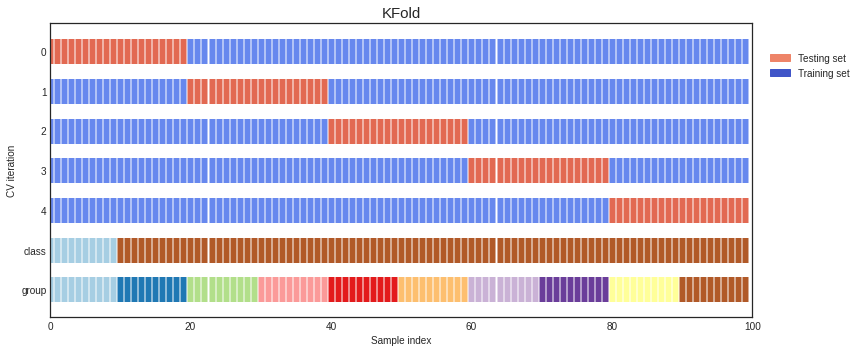

In [19]:
kf = KFold()
X_, y_, groups_ = get_fake_X_y()
plot_cv(KFold, X_, y_, groups_)

### Stratified KFold
- KFold pero las particiones se realizan conservando la proporción de muestras para cada clase

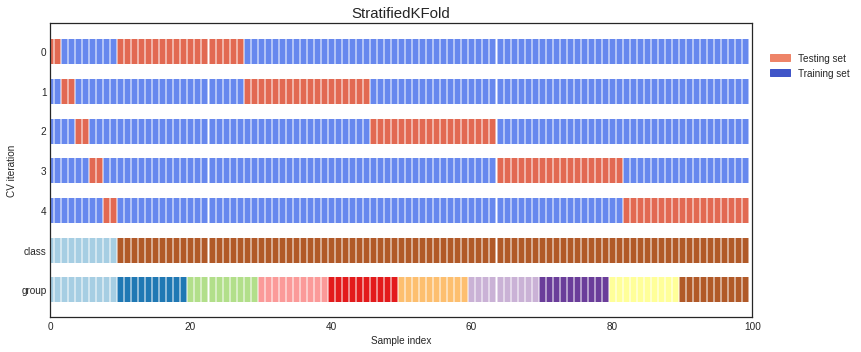

In [20]:
skf = StratifiedKFold()
X_, y_, groups_ = get_fake_X_y()
plot_cv(StratifiedKFold, X_, y_, groups_)

### Group KFold
- Las particiones están equilibradas en el sentido de que el número de grupos distintos es aproximadamente el mismo en cada partición

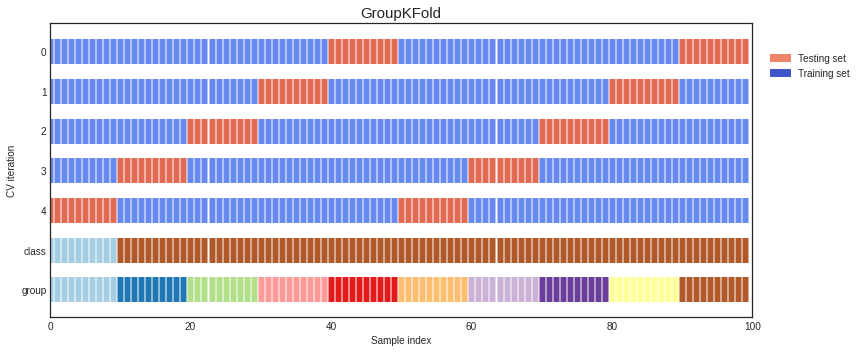

In [21]:
gkf = GroupKFold()
X_, y_, groups_ = get_fake_X_y()
plot_cv(GroupKFold, X_, y_, groups_)

In [22]:
# plot_cv(GroupKFold, )

### Stratified Group KFold

La diferencia entre `GroupKFold` y `StratifiedGroupKFold` es que el primero intenta crear particiones equilibradas de modo que el número de grupos distintos sea aproximadamente el mismo en cada partición, mientras que `StratifiedGroupKFold` intenta crear pliegues que conserven el porcentaje de muestras para cada clase tanto como sea posible dada la restricción de grupos no superpuestos entre divisiones.

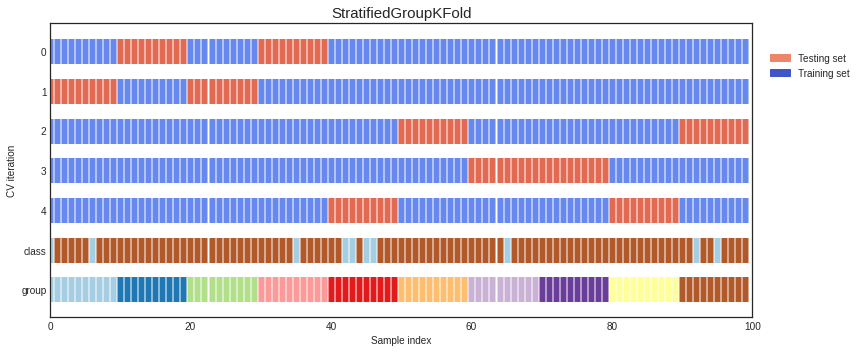

In [23]:
gskf = StratifiedGroupKFold()
X_, y_, groups_ = get_fake_X_y()
np.random.shuffle(y_)
plot_cv(StratifiedGroupKFold, X_, y_, groups_)

### Time Series Split

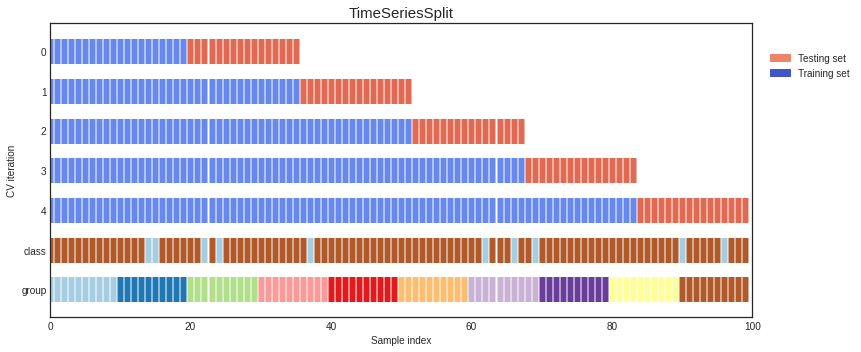

In [24]:
tss = TimeSeriesSplit()
X_, y_, groups_ = get_fake_X_y()
np.random.shuffle(y_)
plot_cv(TimeSeriesSplit, X_, y_, groups_)

## Ejercicio 3: Cross Validation aplicado a SVM 
1. Small/imblanced -> Stratified
2. Group
3. Shuffle in on

`StratifiedGroupKFold` is a good choice for this situation.

In [25]:
# Grouping the groups together
indeces = list(groups.groupby(groups).groups.values())
flat_index = [item for sublist in indeces for item in sublist]

In [26]:
X_, y_, groups_ = X.loc[flat_index], y.loc[flat_index], groups.loc[flat_index]

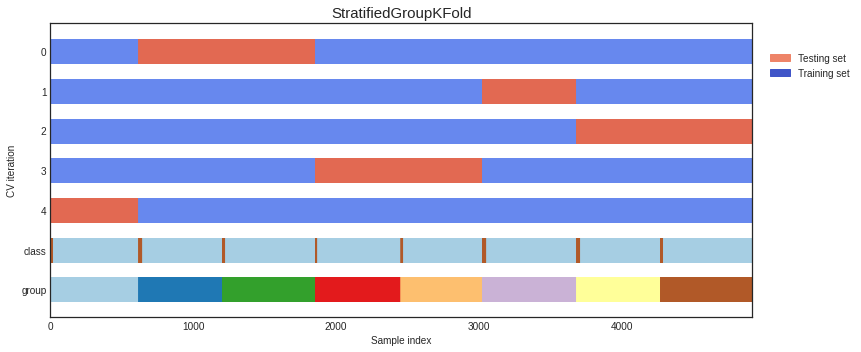

In [27]:
plot_cv(StratifiedGroupKFold, X_, y_, groups_)

In [28]:
def train_with_cv(clf):
    sgk = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=529)

    X, y, groups = get_X_y(df)

    fold = 0
    aucs = []
    for train_idx, val_idx in sgk.split(X, y, groups):
        X_tr = X.loc[train_idx]
        y_tr = y.loc[train_idx]

        X_val = X.loc[val_idx]
        y_val = y.loc[val_idx]

        # Fit Model on Train
        clf.fit(X_tr, y_tr)
        pred = clf.predict_proba(X_val)[:,1]
        auc_score = roc_auc_score(y_val, pred)
        print(f"======= Fold {fold} ========")
        print(
            f"Our AUC on the validation set is {auc_score:0.4f}"
        )
        fold += 1
        aucs.append(auc_score)
    oof_auc = np.mean(aucs)
    print(f'Our out of fold AUC score is {oof_auc:0.4f}')

In [29]:
train_with_cv(SVC(probability=True))

======= Fold 0 ========
Our AUC on the validation set is 0.7495
======= Fold 1 ========
Our AUC on the validation set is 0.5993
======= Fold 2 ========
Our AUC on the validation set is 0.7704
======= Fold 3 ========
Our AUC on the validation set is 0.7941
======= Fold 4 ========
Our AUC on the validation set is 0.2545
Our out of fold AUC score is 0.6336


Our averaged out of fold score is a much better estimation of how our model will perform on unseen data.

## Ejercicio 4: Cross Validation para el resto de los clasificadores

Entrenemos en el dataset para predecir ataques al corazón cada uno de los clasificadores estudiados en el curso hasta el momento y evaluemos el rendimiento aplicando cross validation.

In [30]:
from sklearn.naive_bayes import GaussianNB

train_with_cv(GaussianNB())

======= Fold 0 ========
Our AUC on the validation set is 0.8308
======= Fold 1 ========
Our AUC on the validation set is 0.7869
======= Fold 2 ========
Our AUC on the validation set is 0.7766
======= Fold 3 ========
Our AUC on the validation set is 0.8452
======= Fold 4 ========
Our AUC on the validation set is 0.8434
Our out of fold AUC score is 0.8166


In [31]:
from sklearn.neighbors import KNeighborsClassifier

train_with_cv(KNeighborsClassifier())

======= Fold 0 ========
Our AUC on the validation set is 0.6505
======= Fold 1 ========
Our AUC on the validation set is 0.5777
======= Fold 2 ========
Our AUC on the validation set is 0.6035
======= Fold 3 ========
Our AUC on the validation set is 0.6371
======= Fold 4 ========
Our AUC on the validation set is 0.5917
Our out of fold AUC score is 0.6121


In [32]:
from sklearn.tree import DecisionTreeClassifier

train_with_cv(DecisionTreeClassifier(criterion="entropy"))

======= Fold 0 ========
Our AUC on the validation set is 0.5125
======= Fold 1 ========
Our AUC on the validation set is 0.5114
======= Fold 2 ========
Our AUC on the validation set is 0.5255
======= Fold 3 ========
Our AUC on the validation set is 0.5476
======= Fold 4 ========
Our AUC on the validation set is 0.5273
Our out of fold AUC score is 0.5249


In [33]:
from sklearn.ensemble import RandomForestClassifier

train_with_cv(RandomForestClassifier(criterion="entropy"))

======= Fold 0 ========
Our AUC on the validation set is 0.7932
======= Fold 1 ========
Our AUC on the validation set is 0.7740
======= Fold 2 ========
Our AUC on the validation set is 0.7803
======= Fold 3 ========
Our AUC on the validation set is 0.8185
======= Fold 4 ========
Our AUC on the validation set is 0.7701
Our out of fold AUC score is 0.7872


In [34]:
from sklearn.linear_model import LogisticRegression

train_with_cv(LogisticRegression(solver='liblinear'))

======= Fold 0 ========
Our AUC on the validation set is 0.8311
======= Fold 1 ========
Our AUC on the validation set is 0.8052
======= Fold 2 ========
Our AUC on the validation set is 0.8363
======= Fold 3 ========
Our AUC on the validation set is 0.8624
======= Fold 4 ========
Our AUC on the validation set is 0.8222
Our out of fold AUC score is 0.8314


## Ejercicio 5: Otros clasificadores

Para concluir vamos a usar otros clasificadores que no son objetivo del curso y evaluarlos también usando cross-validation.

In [39]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

clf1 = GradientBoostingClassifier(n_estimators=100, learning_rate=1,max_depth=3, random_state=0)
clf2 = HistGradientBoostingClassifier(min_samples_leaf=10)

In [40]:
train_with_cv(clf1)

======= Fold 0 ========
Our AUC on the validation set is 0.7804
======= Fold 1 ========
Our AUC on the validation set is 0.6335
======= Fold 2 ========
Our AUC on the validation set is 0.7265
======= Fold 3 ========
Our AUC on the validation set is 0.7749
======= Fold 4 ========
Our AUC on the validation set is 0.7802
Our out of fold AUC score is 0.7391


In [ ]:
train_with_cv(clf2)